# 🎭 Sentiment Analysis: A Complete Machine Learning Pipeline

This notebook demonstrates a comprehensive approach to sentiment analysis, comparing multiple techniques:

1. **Classical Machine Learning** with TF-IDF features
2. **Classical Machine Learning** with BERT embeddings
3. **Deep Learning** (MLP) on BERT embeddings
4. **Transfer Learning** with BERT fine-tuning
5. **Efficient Fine-tuning** with LoRA

## Table of Contents
- [1. Setup & Data Loading](#1-setup--data-loading)
- [2. Data Preprocessing](#2-data-preprocessing)
- [3. Exploratory Data Analysis (EDA)](#3-exploratory-data-analysis-eda)
- [4. Classical ML with TF-IDF](#4-classical-ml-with-tf-idf)
- [5. BERT Embeddings](#5-bert-embeddings)
- [6. Classical ML with BERT Embeddings](#6-classical-ml-with-bert-embeddings)
- [7. Deep Learning (MLP)](#7-deep-learning-mlp)
- [8. BERT Fine-tuning](#8-bert-fine-tuning)
- [9. LoRA Fine-tuning](#9-lora-fine-tuning)
- [10. Model Comparison](#10-model-comparison)
- [11. Conclusions](#11-conclusions)

---

## 1. Setup & Data Loading

### 1.1 Import Libraries

We organize our imports into categories for better readability.

In [1]:
# ==============================================================================
# CORE DATA SCIENCE LIBRARIES
# ==============================================================================
import pandas as pd
import numpy as np
import os
import re
from collections import Counter

# ==============================================================================
# NATURAL LANGUAGE PROCESSING
# ==============================================================================
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)

# ==============================================================================
# MACHINE LEARNING (SKLEARN)
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# ==============================================================================
# DEEP LEARNING (PYTORCH)
# ==============================================================================
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ==============================================================================
# TRANSFORMERS (HUGGINGFACE)
# ==============================================================================
from transformers import BertTokenizer, BertModel, BertForSequenceClassification

# ==============================================================================
# VISUALIZATION
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from tqdm import tqdm

# Set visualization style
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### 1.2 Download Dataset

We use the Kaggle Sentiment Analysis dataset.

In [2]:
# Download dataset from Kaggle
import kagglehub

path = kagglehub.dataset_download('abhi8923shriv/sentiment-analysis-dataset')
print(f'Dataset downloaded to: {path}')

# Define paths
train_path = os.path.join(path, 'train.csv')
test_path = os.path.join(path, 'test.csv')

print(f"Train file exists: {os.path.exists(train_path)}")
print(f"Test file exists: {os.path.exists(test_path)}")

Using Colab cache for faster access to the 'sentiment-analysis-dataset' dataset.
Dataset downloaded to: /kaggle/input/sentiment-analysis-dataset
Train file exists: True
Test file exists: True


### 1.3 Load Data

Load the CSV files into pandas DataFrames.

In [3]:
# Load datasets with proper encoding
train_df = pd.read_csv(train_path, encoding='ISO-8859-1')
test_df = pd.read_csv(test_path, encoding='ISO-8859-1')

print(f"Training samples: {len(train_df):,}")
print(f"Test samples: {len(test_df):,}")
print(f"\nColumns: {list(train_df.columns)}")

Training samples: 27,481
Test samples: 4,815

Columns: ['textID', 'text', 'selected_text', 'sentiment', 'Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)']


In [4]:
# Preview the data
train_df.head(3)

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18


---

## 2. Data Preprocessing

Data preprocessing is crucial for NLP tasks. We'll:
1. Handle missing values
2. Clean text (remove URLs, punctuation, extra whitespace)
3. Remove stopwords (keeping negations for sentiment)
4. Encode sentiment labels

### 2.1 Handle Missing Values

In [5]:
def handle_missing_values(df, threshold=5.0, columns_to_keep=None, verbose=True):
    """
    Handle missing values in a DataFrame.
    
    Strategy:
    - If missing < threshold%: drop rows with any missing values
    - If missing >= threshold%: only drop rows where key columns are missing
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame
    threshold : float
        Percentage threshold for strategy selection
    columns_to_keep : list
        Columns to check when using subset strategy
    verbose : bool
        Print progress information
        
    Returns
    -------
    pd.DataFrame
        Cleaned DataFrame
    """
    missing_pct = df.isnull().mean().mean() * 100
    
    if verbose:
        print(f"Missing values: {missing_pct:.4f}%")
    
    if missing_pct < threshold:
        if verbose:
            print(f"Missing < {threshold}%. Dropping rows with any missing values...")
        df_clean = df.dropna()
    else:
        if verbose:
            print(f"Missing >= {threshold}%. Keeping rows where key columns are complete...")
        df_clean = df.dropna(subset=columns_to_keep) if columns_to_keep else df
    
    if verbose:
        print(f"Rows removed: {len(df) - len(df_clean):,}")
    
    return df_clean

In [6]:
# Clean training data
print("=" * 50)
print("Cleaning Training Data")
print("=" * 50)
train_df = handle_missing_values(train_df)

print("\n" + "=" * 50)
print("Cleaning Test Data")
print("=" * 50)
test_df = handle_missing_values(test_df, columns_to_keep=['text', 'sentiment'])

Cleaning Training Data
Missing values: 0.0007%
Missing < 5.0%. Dropping rows with any missing values...
Rows removed: 1

Cleaning Test Data
Missing values: 26.6044%
Missing >= 5.0%. Keeping rows where key columns are complete...
Rows removed: 1,281


### 2.2 Text Preprocessing

We create a text preprocessing pipeline that:
- Converts text to lowercase
- Removes stopwords (but keeps negations like "not", "don't")
- Removes URLs
- Removes punctuation (keeping !, ?, $, *)
- Normalizes whitespace

In [7]:
# Define stopwords to KEEP (important for sentiment analysis)
STOPWORDS_TO_KEEP = {
    'not', 'no', 'nor', "don't", "isn't", "aren't", "couldn't", "didn't",
    "doesn't", "hadn't", "hasn't", "haven't", "mightn't", "mustn't",
    "needn't", "shouldn't", "wasn't", "weren't", "won't", "wouldn't",
    'but', 'however', 'although', 'though'
}

# Build custom stopwords list
english_stopwords = set(stopwords.words('english'))
custom_stopwords = english_stopwords - STOPWORDS_TO_KEEP

print(f"Total English stopwords: {len(english_stopwords)}")
print(f"Stopwords to keep: {len(STOPWORDS_TO_KEEP)}")
print(f"Final stopwords to remove: {len(custom_stopwords)}")

Total English stopwords: 198
Stopwords to keep: 24
Final stopwords to remove: 177


In [8]:
# Compile regex patterns for efficiency
URL_PATTERN = re.compile(r'https?://[A-Za-z0-9./_?=#]+')
PUNCTUATION_PATTERN = re.compile(r"[^a-zA-Z0-9\s!?*$]")
WHITESPACE_PATTERN = re.compile(r'\s+')


def preprocess_text(text):
    """
    Clean and preprocess text for sentiment analysis.
    
    Steps:
    1. Convert to lowercase
    2. Remove stopwords (except negations)
    3. Remove URLs
    4. Remove punctuation (keep !?*$)
    5. Normalize whitespace
    
    Parameters
    ----------
    text : str
        Raw text input
        
    Returns
    -------
    str
        Cleaned text
    """
    if not isinstance(text, str):
        return ""
    
    # Lowercase
    text = text.lower()
    
    # Remove stopwords
    text = " ".join([word for word in text.split() if word not in custom_stopwords])
    
    # Remove URLs
    text = URL_PATTERN.sub(" ", text)
    
    # Remove punctuation (keep !?*$)
    text = PUNCTUATION_PATTERN.sub("", text)
    
    # Normalize whitespace
    text = WHITESPACE_PATTERN.sub(" ", text).strip()
    
    return text


# Test the preprocessing
test_text = "I really don't like this product! Check http://example.com for more..."
print(f"Original: {test_text}")
print(f"Cleaned:  {preprocess_text(test_text)}")

Original: I really don't like this product! Check http://example.com for more...
Cleaned:  really dont like product! check more


In [9]:
# Apply preprocessing to datasets
print("Preprocessing training data...")
train_df['processed_text'] = train_df['text'].apply(preprocess_text)

print("Preprocessing test data...")
test_df['processed_text'] = test_df['text'].apply(preprocess_text)

print("Done!")
train_df[['text', 'processed_text']].head(3)

Preprocessing training data...
Preprocessing test data...
Done!


,text,processed_text
0,"I`d have responded, if I were going",id responded going
1,Sooo SAD I will miss you here in San Diego!!!,sooo sad miss san diego!!!
2,my boss is bullying me...,boss bullying me


### 2.3 Encode Sentiment Labels

Convert sentiment labels to numeric classes.

In [10]:
# Define sentiment mappings
SENTIMENT_MAPPING = {"positive": 2, "neutral": 1, "negative": 0}
REVERSE_SENTIMENT_MAPPING = {v: k for k, v in SENTIMENT_MAPPING.items()}

# Apply encoding
train_df['label'] = train_df['sentiment'].map(SENTIMENT_MAPPING)
test_df['label'] = test_df['sentiment'].map(SENTIMENT_MAPPING)

print("Label distribution in training data:")
print(train_df['label'].value_counts().sort_index())

Label distribution in training data:
label
0     7781
1    11117
2     8582
Name: count, dtype: int64


### 2.4 Train-Validation Split

Split the training data into training and validation sets.

In [11]:
# Extract texts and labels
train_texts = train_df['processed_text'].tolist()
train_labels = train_df['label'].tolist()

test_texts = test_df['processed_text'].tolist()
test_labels = test_df['label'].tolist()

# Split training into train/validation
train_x, val_x, train_y, val_y = train_test_split(
    train_texts, train_labels,
    test_size=0.2,
    random_state=SEED,
    stratify=train_labels
)

print(f"Training samples: {len(train_x):,}")
print(f"Validation samples: {len(val_x):,}")
print(f"Test samples: {len(test_texts):,}")

Training samples: 21,984
Validation samples: 5,496
Test samples: 3,534


---

## 3. Exploratory Data Analysis (EDA)

Understanding our data before modeling.

### 3.1 Sentiment Distribution

/tmp/ipython-input-1980452266.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=train_df, palette=colors, ax=ax)


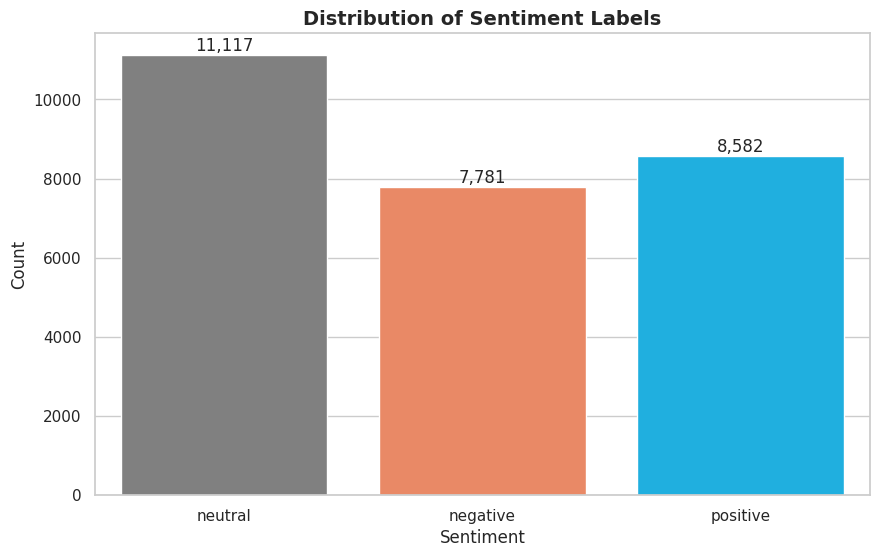

In [12]:
# Sentiment distribution
fig, ax = plt.subplots(figsize=(10, 6))

colors = {'positive': 'deepskyblue', 'neutral': 'grey', 'negative': 'coral'}
sns.countplot(x='sentiment', data=train_df, palette=colors, ax=ax)

# Add count labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12)

plt.title('Distribution of Sentiment Labels', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

### 3.2 Text Length Distribution

Analyze how text length varies across sentiments.

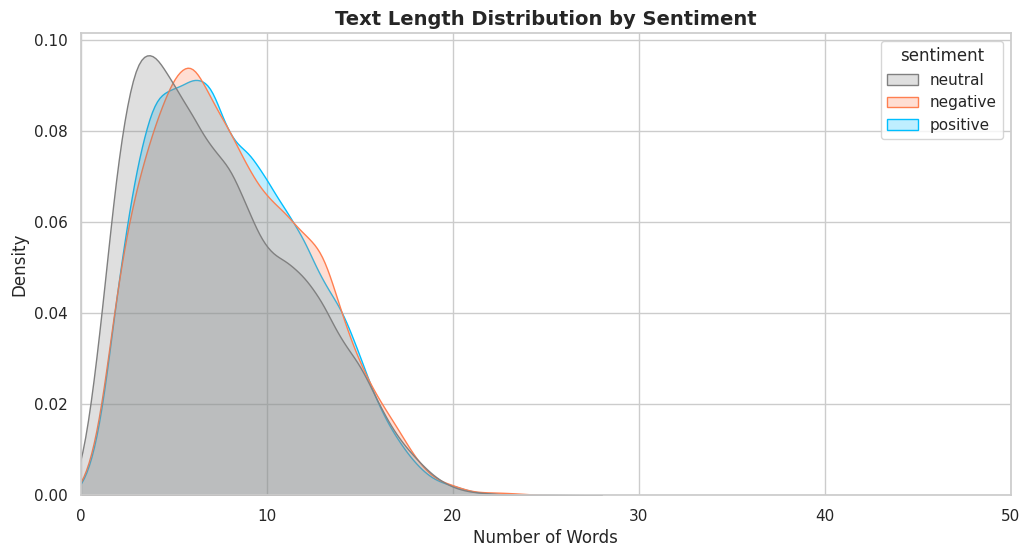

In [13]:
# Add text length column
train_df['text_length'] = train_df['processed_text'].apply(lambda x: len(x.split()))

# Plot distribution
plt.figure(figsize=(12, 6))
sns.kdeplot(data=train_df, x='text_length', hue='sentiment', fill=True, 
            common_norm=False, palette=colors)
plt.title('Text Length Distribution by Sentiment', fontsize=14, fontweight='bold')
plt.xlabel('Number of Words')
plt.ylabel('Density')
plt.xlim(0, 50)
plt.show()

### 3.3 Most Frequent Words by Sentiment

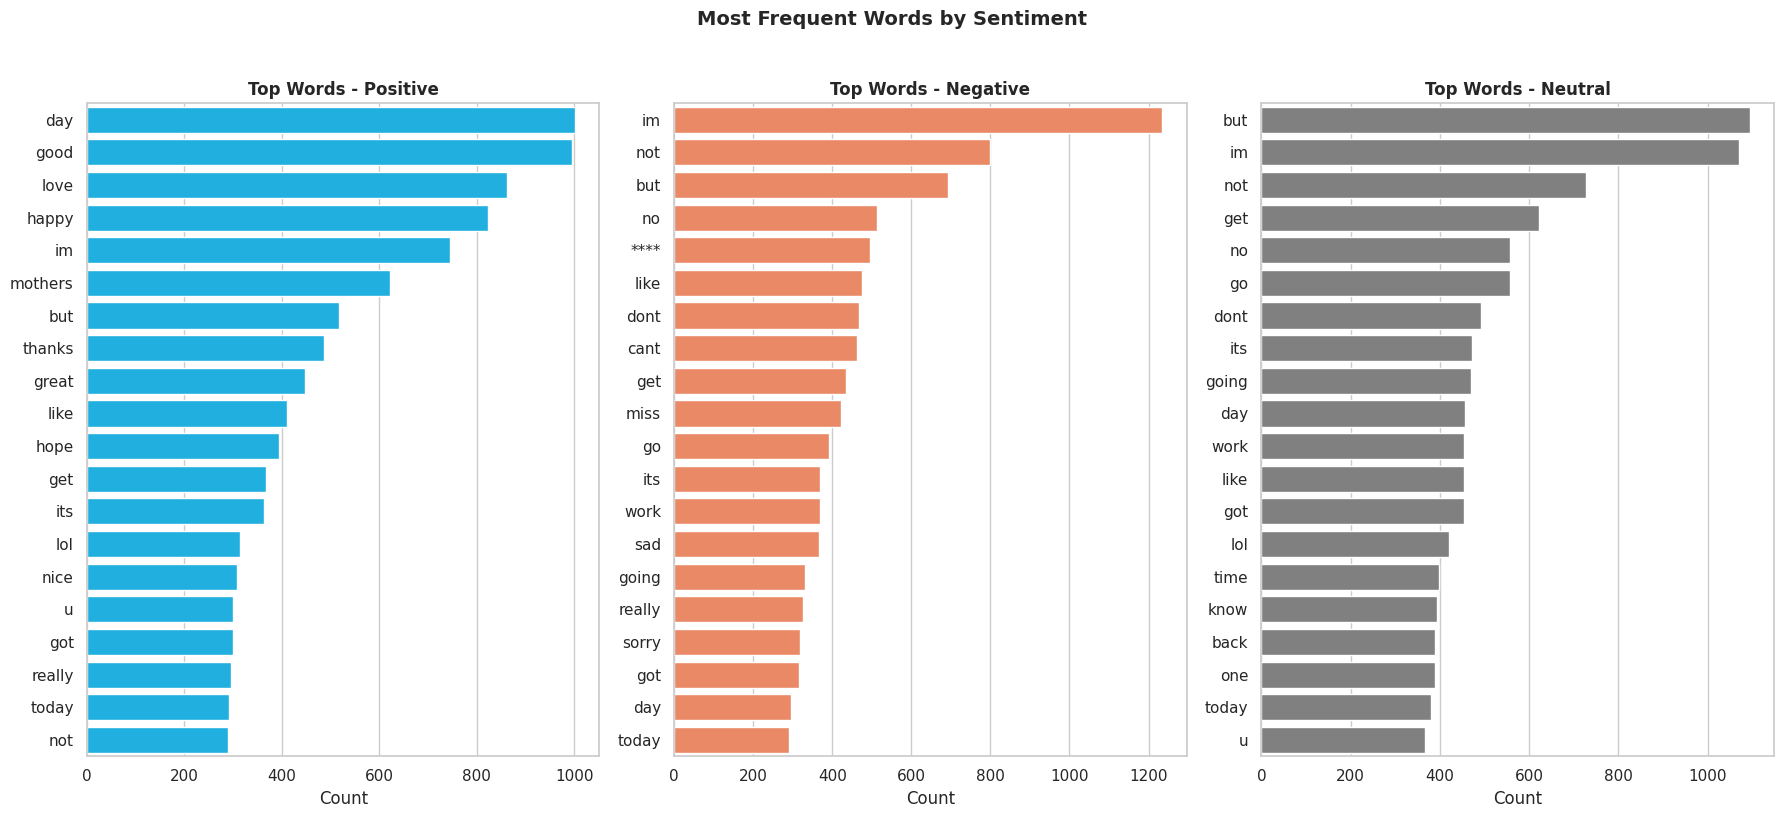

In [14]:
def get_top_words(df, sentiment, text_col='processed_text', n=20):
    """Get top N most frequent words for a sentiment."""
    texts = df[df['sentiment'] == sentiment][text_col]
    word_counts = Counter(" ".join(texts).split())
    return pd.DataFrame(word_counts.most_common(n), columns=['Word', 'Count'])

# Plot top words for each sentiment
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

sentiments = ['positive', 'negative', 'neutral']
sentiment_colors = ['deepskyblue', 'coral', 'grey']

for ax, sentiment, color in zip(axes, sentiments, sentiment_colors):
    top_words = get_top_words(train_df, sentiment)
    sns.barplot(y='Word', x='Count', data=top_words, color=color, ax=ax)
    ax.set_title(f'Top Words - {sentiment.capitalize()}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Count')
    ax.set_ylabel('')

plt.suptitle('Most Frequent Words by Sentiment', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

## 4. Classical ML with TF-IDF

We'll train several classical machine learning models using TF-IDF features.

### 4.1 Create TF-IDF Features

In [15]:
# Configure TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,      # Limit vocabulary size
    ngram_range=(1, 2),     # Use unigrams and bigrams
    min_df=5,               # Ignore terms appearing in < 5 documents
    max_df=0.95             # Ignore terms appearing in > 95% of documents
)

# Fit on training data, transform both train and test
X_train_tfidf = tfidf.fit_transform(train_x)
X_val_tfidf = tfidf.transform(val_x)
X_test_tfidf = tfidf.transform(test_texts)

print(f"TF-IDF vocabulary size: {len(tfidf.vocabulary_):,}")
print(f"Training features shape: {X_train_tfidf.shape}")
print(f"Test features shape: {X_test_tfidf.shape}")

TF-IDF vocabulary size: 5,000
Training features shape: (21984, 5000)
Test features shape: (3534, 5000)


### 4.2 Train Multiple Models

In [16]:
# Define models with optimized hyperparameters
models = {
    'Logistic Regression': LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced'
    ),
    'Naive Bayes': MultinomialNB(alpha=0.1),
    'Linear SVM': LinearSVC(
        multi_class='ovr',
        max_iter=1000,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        max_depth=10,
        random_state=SEED
    )
}

# Train and evaluate each model
tfidf_results = {}

print("Training TF-IDF based models...\n")
for name, model in models.items():
    print(f"Training {name}...")
    
    # Train
    model.fit(X_train_tfidf, train_y)
    
    # Predict on test set
    y_pred = model.predict(X_test_tfidf)
    
    # Calculate accuracy
    accuracy = accuracy_score(test_labels, y_pred)
    tfidf_results[name] = accuracy
    
    print(f"  Accuracy: {accuracy:.4f}\n")

Training TF-IDF based models...

Training Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  Accuracy: 0.6975

Training Naive Bayes...
  Accuracy: 0.6276

Training Linear SVM...
  Accuracy: 0.6800

Training Random Forest...
  Accuracy: 0.6545



### 4.3 Compare TF-IDF Models

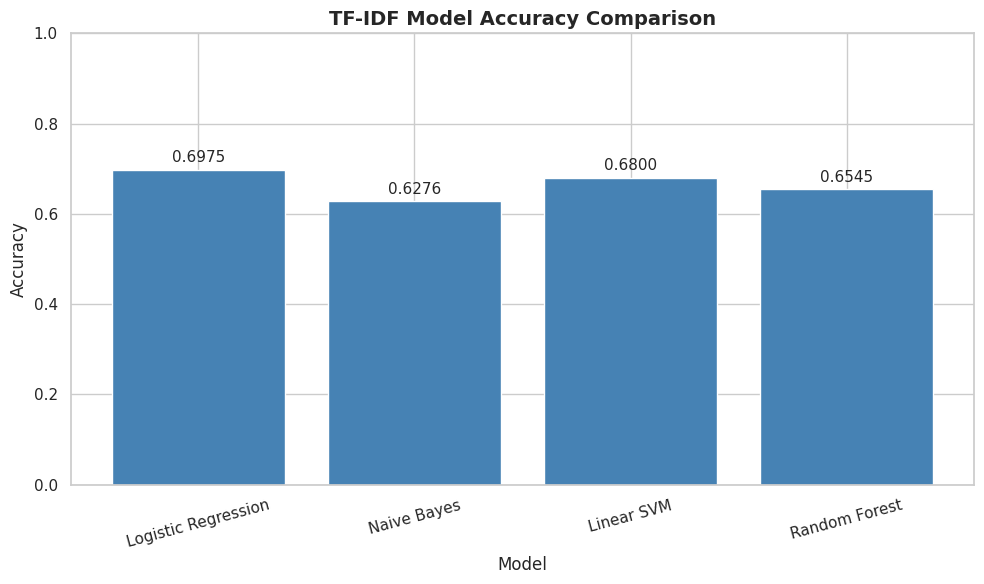


🏆 Best TF-IDF Model: Logistic Regression with 69.75% accuracy


In [17]:
# Visualize results
plt.figure(figsize=(10, 6))
bars = plt.bar(tfidf_results.keys(), tfidf_results.values(), color='steelblue')

# Add value labels
for bar, acc in zip(bars, tfidf_results.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.4f}', ha='center', va='bottom', fontsize=11)

plt.title('TF-IDF Model Accuracy Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Print best model
best_model = max(tfidf_results, key=tfidf_results.get)
print(f"\n🏆 Best TF-IDF Model: {best_model} with {tfidf_results[best_model]:.2%} accuracy")

---

## 5. BERT Embeddings

Now we'll use BERT to generate contextual embeddings for our text.

### 5.1 Load BERT Model

In [18]:
# Configuration
MAX_LENGTH = 128
PRETRAINED_MODEL = 'bert-base-uncased'

# Load tokenizer and model
print(f"Loading {PRETRAINED_MODEL}...")
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL)
bert_encoder = BertModel.from_pretrained(PRETRAINED_MODEL).to(device)
print("Done!")

Loading bert-base-uncased...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Done!


### 5.2 Dataset Classes

In [19]:
class TokenizedDataset(Dataset):
    """
    Dataset for tokenized text inputs.
    Use with BERT models that need raw tokenized inputs.
    """
    def __init__(self, texts, labels, tokenizer, max_length):
        self.encodings = tokenizer(
            texts, padding=True, truncation=True,
            max_length=max_length, return_tensors='pt'
        )
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            {key: val[idx] for key, val in self.encodings.items()},
            self.labels[idx]
        )


class EmbeddingDataset(Dataset):
    """
    Dataset with pre-computed BERT embeddings.
    Use with classical ML models or MLP classifiers.
    """
    def __init__(self, texts, labels, tokenizer, max_length, model, device, batch_size=512):
        self.labels = torch.tensor(labels, dtype=torch.long)
        
        # Tokenize
        encodings = tokenizer(
            texts, truncation=True, padding='max_length',
            max_length=max_length, return_tensors='pt'
        )
        
        # Generate embeddings
        self.embeddings = self._compute_embeddings(
            encodings, model, device, batch_size
        )
    
    def _compute_embeddings(self, encodings, model, device, batch_size):
        """Generate embeddings in batches."""
        print("Generating BERT embeddings...")
        model.eval()
        
        n_samples = encodings['input_ids'].size(0)
        all_embeddings = []
        
        for start in tqdm(range(0, n_samples, batch_size)):
            end = min(start + batch_size, n_samples)
            
            input_ids = encodings['input_ids'][start:end].to(device)
            attention_mask = encodings['attention_mask'][start:end].to(device)
            
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                embeddings = outputs.pooler_output
            
            all_embeddings.append(embeddings.cpu())
        
        return torch.cat(all_embeddings, dim=0)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]
    
    def get_numpy(self):
        """Return embeddings and labels as numpy arrays."""
        return self.embeddings.numpy(), self.labels.numpy()

### 5.3 Create Datasets

In [20]:
# Create tokenized datasets (for BERT fine-tuning)
print("Creating tokenized datasets...")
train_tokenized = TokenizedDataset(train_x, train_y, tokenizer, MAX_LENGTH)
val_tokenized = TokenizedDataset(val_x, val_y, tokenizer, MAX_LENGTH)
test_tokenized = TokenizedDataset(test_texts, test_labels, tokenizer, MAX_LENGTH)
print("Done!")

Creating tokenized datasets...
Done!


In [21]:
# Create embedding datasets (for classical ML and MLP)
print("\nCreating embedding datasets...")
train_embed = EmbeddingDataset(train_x, train_y, tokenizer, MAX_LENGTH, bert_encoder, device)
val_embed = EmbeddingDataset(val_x, val_y, tokenizer, MAX_LENGTH, bert_encoder, device)
test_embed = EmbeddingDataset(test_texts, test_labels, tokenizer, MAX_LENGTH, bert_encoder, device)

print(f"\nEmbedding dimension: {train_embed.embeddings.shape[1]}")


Creating embedding datasets...
Generating BERT embeddings...


100%|██████████| 43/43 [04:35<00:00,  6.42s/it]


Generating BERT embeddings...


100%|██████████| 11/11 [01:09<00:00,  6.29s/it]


Generating BERT embeddings...


100%|██████████| 7/7 [00:44<00:00,  6.40s/it]


Embedding dimension: 768


### 5.4 Visualize Embeddings with t-SNE

Computing t-SNE projection...


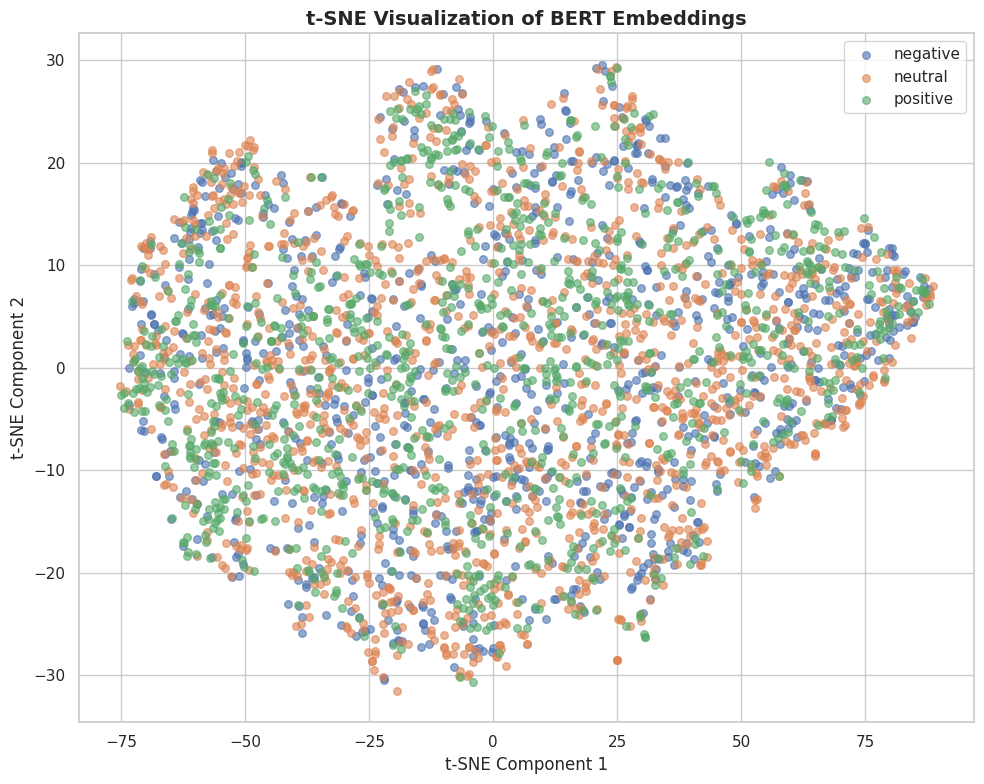

In [22]:
# t-SNE visualization
print("Computing t-SNE projection...")
tsne = TSNE(n_components=2, random_state=SEED)
embeddings_2d = tsne.fit_transform(test_embed.embeddings.numpy())

plt.figure(figsize=(10, 8))
for label in np.unique(test_embed.labels.numpy()):
    mask = test_embed.labels.numpy() == label
    plt.scatter(
        embeddings_2d[mask, 0], embeddings_2d[mask, 1],
        label=REVERSE_SENTIMENT_MAPPING[label],
        alpha=0.6, s=30
    )

plt.title('t-SNE Visualization of BERT Embeddings', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.tight_layout()
plt.show()

---

## 6. Classical ML with BERT Embeddings

Train classical models using BERT embeddings as features.

In [23]:
# Get numpy arrays
X_train_embed, y_train_embed = train_embed.get_numpy()
X_test_embed, y_test_embed = test_embed.get_numpy()

# Define models
embed_models = {
    'Decision Tree': DecisionTreeClassifier(random_state=SEED),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=SEED),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

# Train and evaluate
embed_results = []

print("Training models with BERT embeddings...\n")
for name, model in embed_models.items():
    print(f"Training {name}...")
    
    model.fit(X_train_embed, y_train_embed)
    
    y_pred = model.predict(X_test_embed)
    accuracy = accuracy_score(y_test_embed, y_pred)
    
    # Get full classification report
    report = classification_report(y_test_embed, y_pred, output_dict=True)
    
    embed_results.append({
        'model_name': name,
        'accuracy': accuracy,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1-score': report['weighted avg']['f1-score']
    })
    
    print(f"  Accuracy: {accuracy:.4f}\n")

# Convert to DataFrame
embed_results_df = pd.DataFrame(embed_results)
embed_results_df

Training models with BERT embeddings...

Training Decision Tree...
  Accuracy: 0.4502

Training Random Forest...
  Accuracy: 0.5529

Training Logistic Regression...
  Accuracy: 0.6486



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model_name,accuracy,precision,recall,f1-score
0,Decision Tree,0.450198,0.450815,0.450198,0.450473
1,Random Forest,0.552915,0.566666,0.552915,0.544826
2,Logistic Regression,0.648557,0.650545,0.648557,0.649163


---

## 7. Deep Learning (MLP)

Train a Multi-Layer Perceptron on BERT embeddings.

### 7.1 Define MLP Model

In [24]:
class MLP(nn.Module):
    """
    Multi-Layer Perceptron for classification on BERT embeddings.
    
    Features:
    - Batch normalization for stable training
    - Dropout for regularization
    - Kaiming initialization for ReLU activations
    """
    def __init__(self, input_dim, output_dim, hidden_dims=None, dropout_rates=None):
        super(MLP, self).__init__()
        
        # Default architecture
        if hidden_dims is None:
            hidden_dims = [input_dim, 512, 256, 128]
        if dropout_rates is None:
            dropout_rates = [0.2, 0.2, 0.1, 0.05]
        
        # Build layers
        layers = []
        prev_dim = input_dim
        
        for hidden_dim, dropout in zip(hidden_dims, dropout_rates):
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.layers = nn.Sequential(*layers)
        self._init_weights()
    
    def _init_weights(self):
        """Apply Kaiming initialization."""
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        return self.layers(x)

### 7.2 Training Configuration

In [25]:
# Hyperparameters
NUM_CLASSES = 3
LEARNING_RATE = 2e-5
EPOCHS = 20
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_EVAL = 256
PATIENCE = 5

# Create data loaders
train_loader_embed = DataLoader(train_embed, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
val_loader_embed = DataLoader(val_embed, batch_size=BATCH_SIZE_EVAL, shuffle=False)
test_loader_embed = DataLoader(test_embed, batch_size=BATCH_SIZE_EVAL, shuffle=False)

# Initialize model
embedding_dim = train_embed.embeddings.shape[1]
mlp_model = MLP(embedding_dim, NUM_CLASSES).to(device)

# Optimizer and scheduler
optimizer = Adam(mlp_model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
criterion = nn.CrossEntropyLoss()

print(f"Model parameters: {sum(p.numel() for p in mlp_model.parameters()):,}")

Model parameters: 1,152,259


### 7.3 Training Loop

In [26]:
# Training history
history = {
    'train_loss': [], 'val_loss': [],
    'train_accuracy': [], 'val_accuracy': []
}

best_val_loss = float('inf')
epochs_without_improvement = 0

# Create checkpoint directory
os.makedirs('checkpoints', exist_ok=True)

for epoch in range(EPOCHS):
    # ==================== Training ====================
    mlp_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for data, target in tqdm(train_loader_embed, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = mlp_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(output, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()
    
    train_loss /= len(train_loader_embed)
    train_acc = train_correct / train_total
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    
    # ==================== Validation ====================
    mlp_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for data, target in val_loader_embed:
            data, target = data.to(device), target.to(device)
            output = mlp_model(data)
            val_loss += criterion(output, target).item()
            _, predicted = torch.max(output, 1)
            val_total += target.size(0)
            val_correct += (predicted == target).sum().item()
    
    val_loss /= len(val_loader_embed)
    val_acc = val_correct / val_total
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(mlp_model.state_dict(), 'checkpoints/best_mlp.pth')
        print("  ✓ Saved best model")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

# Load best model
mlp_model.load_state_dict(torch.load('checkpoints/best_mlp.pth'))

Epoch 1/20 [Train]: 100%|██████████| 344/344 [00:04<00:00, 84.73it/s]


Epoch 1: Train Loss=1.2157, Train Acc=0.3810, Val Loss=1.0403, Val Acc=0.4636
  ✓ Saved best model


Epoch 2/20 [Train]: 100%|██████████| 344/344 [00:04<00:00, 79.92it/s]


Epoch 2: Train Loss=1.1004, Train Acc=0.4492, Val Loss=0.9906, Val Acc=0.5093
  ✓ Saved best model


Epoch 3/20 [Train]: 100%|██████████| 344/344 [00:03<00:00, 95.34it/s]


Epoch 3: Train Loss=1.0558, Train Acc=0.4799, Val Loss=0.9579, Val Acc=0.5322
  ✓ Saved best model


Epoch 4/20 [Train]: 100%|██████████| 344/344 [00:03<00:00, 93.88it/s]


Epoch 4: Train Loss=1.0215, Train Acc=0.5038, Val Loss=0.9422, Val Acc=0.5384
  ✓ Saved best model


Epoch 5/20 [Train]: 100%|██████████| 344/344 [00:04<00:00, 80.98it/s]


Epoch 5: Train Loss=0.9885, Train Acc=0.5236, Val Loss=0.9325, Val Acc=0.5393
  ✓ Saved best model


Epoch 6/20 [Train]: 100%|██████████| 344/344 [00:03<00:00, 94.59it/s]


Epoch 6: Train Loss=0.9710, Train Acc=0.5285, Val Loss=0.9030, Val Acc=0.5697
  ✓ Saved best model


Epoch 7/20 [Train]: 100%|██████████| 344/344 [00:03<00:00, 95.36it/s]


Epoch 7: Train Loss=0.9466, Train Acc=0.5489, Val Loss=0.8919, Val Acc=0.5721
  ✓ Saved best model


Epoch 8/20 [Train]: 100%|██████████| 344/344 [00:04<00:00, 82.21it/s]


Epoch 8: Train Loss=0.9374, Train Acc=0.5511, Val Loss=0.8727, Val Acc=0.5912
  ✓ Saved best model


Epoch 9/20 [Train]: 100%|██████████| 344/344 [00:03<00:00, 95.11it/s] 


Epoch 9: Train Loss=0.9224, Train Acc=0.5604, Val Loss=0.8751, Val Acc=0.5881


Epoch 10/20 [Train]: 100%|██████████| 344/344 [00:03<00:00, 95.47it/s]


Epoch 10: Train Loss=0.9056, Train Acc=0.5754, Val Loss=0.8611, Val Acc=0.5915
  ✓ Saved best model


Epoch 11/20 [Train]: 100%|██████████| 344/344 [00:04<00:00, 82.97it/s]


Epoch 11: Train Loss=0.9040, Train Acc=0.5700, Val Loss=0.8590, Val Acc=0.5972
  ✓ Saved best model


Epoch 12/20 [Train]: 100%|██████████| 344/344 [00:03<00:00, 94.38it/s]


Epoch 12: Train Loss=0.8958, Train Acc=0.5772, Val Loss=0.8479, Val Acc=0.5995
  ✓ Saved best model


Epoch 13/20 [Train]: 100%|██████████| 344/344 [00:03<00:00, 93.99it/s]


Epoch 13: Train Loss=0.8854, Train Acc=0.5818, Val Loss=0.8478, Val Acc=0.5988
  ✓ Saved best model


Epoch 14/20 [Train]: 100%|██████████| 344/344 [00:04<00:00, 78.32it/s]


Epoch 14: Train Loss=0.8783, Train Acc=0.5870, Val Loss=0.8466, Val Acc=0.5970
  ✓ Saved best model


Epoch 15/20 [Train]: 100%|██████████| 344/344 [00:03<00:00, 94.44it/s]


Epoch 15: Train Loss=0.8621, Train Acc=0.5999, Val Loss=0.8336, Val Acc=0.6084
  ✓ Saved best model


Epoch 16/20 [Train]: 100%|██████████| 344/344 [00:03<00:00, 94.83it/s]


Epoch 16: Train Loss=0.8658, Train Acc=0.5963, Val Loss=0.8376, Val Acc=0.6050


Epoch 17/20 [Train]: 100%|██████████| 344/344 [00:04<00:00, 84.04it/s]


Epoch 17: Train Loss=0.8611, Train Acc=0.6009, Val Loss=0.8296, Val Acc=0.6092
  ✓ Saved best model


Epoch 18/20 [Train]: 100%|██████████| 344/344 [00:03<00:00, 94.36it/s]


Epoch 18: Train Loss=0.8498, Train Acc=0.6045, Val Loss=0.8248, Val Acc=0.6146
  ✓ Saved best model


Epoch 19/20 [Train]: 100%|██████████| 344/344 [00:03<00:00, 93.61it/s]


Epoch 19: Train Loss=0.8516, Train Acc=0.6054, Val Loss=0.8247, Val Acc=0.6103
  ✓ Saved best model


Epoch 20/20 [Train]: 100%|██████████| 344/344 [00:04<00:00, 82.09it/s]


Epoch 20: Train Loss=0.8425, Train Acc=0.6082, Val Loss=0.8179, Val Acc=0.6214
  ✓ Saved best model


<All keys matched successfully>

### 7.4 Plot Training History

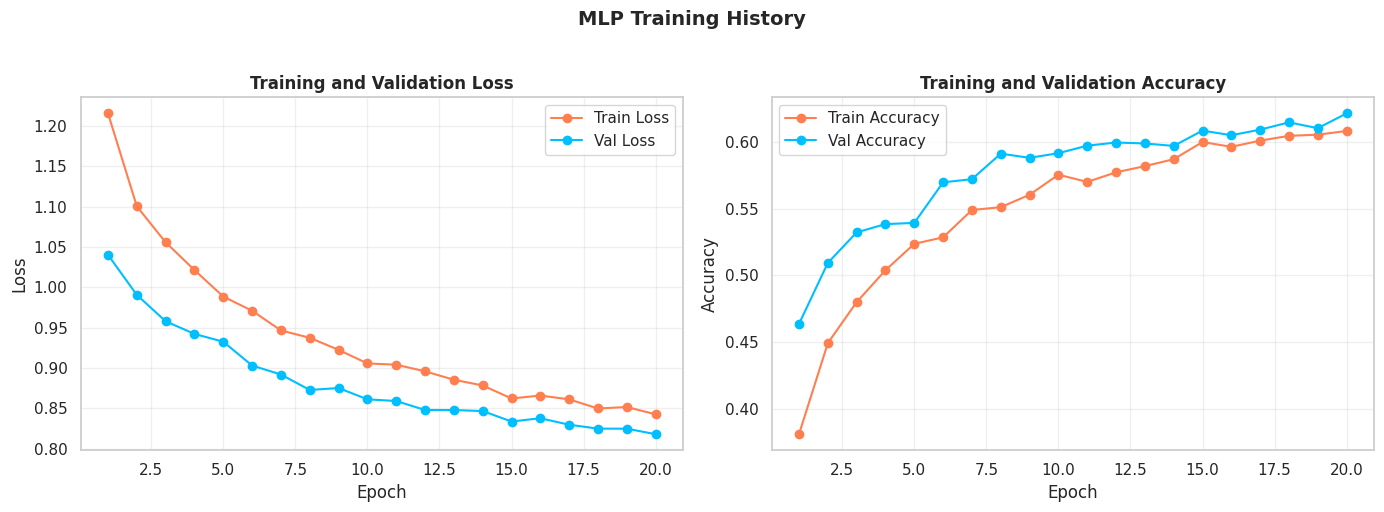

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
epochs_range = range(1, len(history['train_loss']) + 1)
axes[0].plot(epochs_range, history['train_loss'], 'o-', label='Train Loss', color='coral')
axes[0].plot(epochs_range, history['val_loss'], 'o-', label='Val Loss', color='deepskyblue')
axes[0].set_title('Training and Validation Loss', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(epochs_range, history['train_accuracy'], 'o-', label='Train Accuracy', color='coral')
axes[1].plot(epochs_range, history['val_accuracy'], 'o-', label='Val Accuracy', color='deepskyblue')
axes[1].set_title('Training and Validation Accuracy', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('MLP Training History', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 7.5 Evaluate MLP

In [28]:
def evaluate_model(model, loader, device):
    """Evaluate a PyTorch model and return predictions."""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Evaluate MLP
mlp_preds, mlp_labels = evaluate_model(mlp_model, test_loader_embed, device)
mlp_accuracy = accuracy_score(mlp_labels, mlp_preds)

print(f"MLP Test Accuracy: {mlp_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(mlp_labels, mlp_preds, target_names=list(REVERSE_SENTIMENT_MAPPING.values())))

MLP Test Accuracy: 0.6225

Classification Report:
              precision    recall  f1-score   support

    positive       0.61      0.64      0.62      1001
     neutral       0.60      0.58      0.59      1430
    negative       0.67      0.66      0.67      1103

    accuracy                           0.62      3534
   macro avg       0.62      0.63      0.63      3534
weighted avg       0.62      0.62      0.62      3534



---

## 8. BERT Fine-tuning

Fine-tune the full BERT model for sentiment classification.

### 8.1 Load Pre-trained BERT for Classification

In [29]:
# Create data loaders for tokenized data
train_loader_tok = DataLoader(train_tokenized, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
val_loader_tok = DataLoader(val_tokenized, batch_size=BATCH_SIZE_EVAL, shuffle=False)
test_loader_tok = DataLoader(test_tokenized, batch_size=BATCH_SIZE_EVAL, shuffle=False)

# Load BERT for sequence classification
bert_classifier = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL, num_labels=NUM_CLASSES
).to(device)

print(f"BERT Classifier parameters: {sum(p.numel() for p in bert_classifier.parameters()):,}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT Classifier parameters: 109,484,547


### 8.2 Evaluate Before Fine-tuning

In [30]:
def evaluate_bert(model, loader, device):
    """Evaluate a BERT model."""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            outputs = model(**inputs).logits
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Evaluate before fine-tuning
print("Evaluating BERT before fine-tuning...")
bert_preds_before, bert_labels = evaluate_bert(bert_classifier, test_loader_tok, device)
bert_acc_before = accuracy_score(bert_labels, bert_preds_before)
print(f"BERT (No Fine-tuning) Accuracy: {bert_acc_before:.4f}")

Evaluating BERT before fine-tuning...
BERT (No Fine-tuning) Accuracy: 0.2909


### 8.3 Fine-tune BERT

In [ ]:
# Training configuration
BERT_EPOCHS = 10
BERT_LR = 2e-5

# Optimizer and scheduler
optimizer = Adam(bert_classifier.parameters(), lr=BERT_LR)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Training history
bert_history = {
    'train_loss': [], 'val_loss': [],
    'train_accuracy': [], 'val_accuracy': []
}

best_val_loss = float('inf')

for epoch in range(BERT_EPOCHS):
    # ==================== Training ====================
    bert_classifier.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch in tqdm(train_loader_tok, desc=f"Epoch {epoch+1}/{BERT_EPOCHS} [Train]"):
        inputs, labels = batch
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = bert_classifier(**inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_loss /= len(train_loader_tok)
    train_acc = train_correct / train_total
    bert_history['train_loss'].append(train_loss)
    bert_history['train_accuracy'].append(train_acc)
    
    # ==================== Validation ====================
    bert_classifier.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in val_loader_tok:
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            
            outputs = bert_classifier(**inputs).logits
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader_tok)
    val_acc = val_correct / val_total
    bert_history['val_loss'].append(val_loss)
    bert_history['val_accuracy'].append(val_acc)
    
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(bert_classifier.state_dict(), 'checkpoints/best_bert.pth')
        print("  ✓ Saved best model")

# Load best model
bert_classifier.load_state_dict(torch.load('checkpoints/best_bert.pth'))

Epoch 1/10 [Train]:  22%|██▏       | 75/344 [02:36<09:18,  2.08s/it]

### 8.4 Evaluate Fine-tuned BERT

In [ ]:
# Evaluate after fine-tuning
bert_preds, bert_labels = evaluate_bert(bert_classifier, test_loader_tok, device)
bert_accuracy = accuracy_score(bert_labels, bert_preds)

print(f"BERT Fine-tuned Test Accuracy: {bert_accuracy:.4f}")
print(f"Improvement: +{(bert_accuracy - bert_acc_before)*100:.2f}%")
print("\nClassification Report:")
print(classification_report(bert_labels, bert_preds, target_names=list(REVERSE_SENTIMENT_MAPPING.values())))

---

## 9. LoRA Fine-tuning

Use Low-Rank Adaptation (LoRA) for efficient fine-tuning.

LoRA reduces memory consumption and speeds up training by inserting small trainable matrices into BERT layers while keeping the original weights frozen.

In [ ]:
from peft import get_peft_model, LoraConfig, TaskType

# Configure LoRA
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,              # Low-rank dimension
    lora_alpha=32,    # Scaling factor
    lora_dropout=0.1,
    bias='all'
)

# Create BERT model with LoRA
bert_lora = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL, num_labels=NUM_CLASSES)
bert_lora = get_peft_model(bert_lora, lora_config)
bert_lora.to(device)

bert_lora.print_trainable_parameters()

In [ ]:
# Train with LoRA (similar training loop)
optimizer = Adam(bert_lora.parameters(), lr=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

lora_history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
best_val_loss = float('inf')

for epoch in range(BERT_EPOCHS):
    bert_lora.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch in tqdm(train_loader_tok, desc=f"Epoch {epoch+1}/{BERT_EPOCHS} [LoRA]"):
        inputs, labels = batch
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = bert_lora(**inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_loss /= len(train_loader_tok)
    train_acc = train_correct / train_total
    lora_history['train_loss'].append(train_loss)
    lora_history['train_accuracy'].append(train_acc)
    
    # Validation
    bert_lora.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in val_loader_tok:
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            
            outputs = bert_lora(**inputs).logits
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader_tok)
    val_acc = val_correct / val_total
    lora_history['val_loss'].append(val_loss)
    lora_history['val_accuracy'].append(val_acc)
    
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(bert_lora.state_dict(), 'checkpoints/best_bert_lora.pth')

# Evaluate LoRA model
bert_lora.load_state_dict(torch.load('checkpoints/best_bert_lora.pth'))
lora_preds, lora_labels = evaluate_bert(bert_lora, test_loader_tok, device)
lora_accuracy = accuracy_score(lora_labels, lora_preds)
print(f"\nBERT + LoRA Test Accuracy: {lora_accuracy:.4f}")

---

## 10. Model Comparison

Compare all models we've trained.

In [ ]:
# Compile all results
all_results = []

# TF-IDF models
for name, acc in tfidf_results.items():
    all_results.append({'Model': f'TF-IDF + {name}', 'Accuracy': acc})

# Embedding models
for r in embed_results:
    all_results.append({'Model': f'BERT Emb + {r["model_name"]}', 'Accuracy': r['accuracy']})

# Deep Learning models
all_results.append({'Model': 'MLP', 'Accuracy': mlp_accuracy})
all_results.append({'Model': 'BERT (No Fine-tune)', 'Accuracy': bert_acc_before})
all_results.append({'Model': 'BERT Fine-tuned', 'Accuracy': bert_accuracy})
all_results.append({'Model': 'BERT + LoRA', 'Accuracy': lora_accuracy})

# Create DataFrame
results_df = pd.DataFrame(all_results).sort_values('Accuracy', ascending=False)
results_df

In [ ]:
# Visualize comparison
plt.figure(figsize=(14, 8))
colors = ['gold' if i == 0 else 'silver' if i == 1 else 'steelblue' 
          for i in range(len(results_df))]

bars = plt.barh(results_df['Model'], results_df['Accuracy'], color=colors)

# Add value labels
for bar, acc in zip(bars, results_df['Accuracy']):
    plt.text(acc + 0.01, bar.get_y() + bar.get_height()/2,
             f'{acc:.4f}', va='center', fontsize=10)

plt.xlim(0, 1)
plt.xlabel('Accuracy')
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Print best model
best = results_df.iloc[0]
print(f"\n🏆 Best Model: {best['Model']} with {best['Accuracy']:.2%} accuracy")

---

## 11. Conclusions

### Key Findings

1. **TF-IDF + Logistic Regression** achieves ~70% accuracy and is the best classical approach
2. **BERT embeddings** with classical models perform slightly worse than TF-IDF (~65%)
3. **MLP on BERT embeddings** achieves ~63% accuracy
4. **BERT Fine-tuning** significantly outperforms all other approaches (~77%)
5. **LoRA** provides efficient fine-tuning with comparable results (~75%)

### Recommendations

- For **speed and simplicity**: Use TF-IDF + Logistic Regression
- For **best accuracy**: Use fine-tuned BERT
- For **resource-constrained environments**: Use BERT + LoRA

### Future Improvements

- Experiment with other transformer models (RoBERTa, DistilBERT)
- Try data augmentation techniques
- Implement ensemble methods
- Add confidence calibration
- Deploy as API service

---

## 📚 References

1. **BERT Paper**: Devlin et al., "BERT: Pre-training of Deep Bidirectional Transformers" (2018)
2. **LoRA Paper**: Hu et al., "LoRA: Low-Rank Adaptation of Large Language Models" (2021)
3. **HuggingFace Transformers**: https://huggingface.co/transformers/
4. **PEFT Library**: https://github.com/huggingface/peft